2022-07-08 18:39:45,021 [INFO] ** TORCH CUDA version installed and working. **
2022-07-08 18:39:45,021 [INFO] >>>> using GPU


Global seed set to 1337


2022-07-08 18:39:45,753 [INFO] Loading imagenet weights


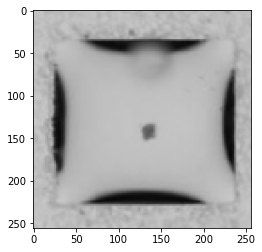

2022-07-08 18:39:46,609 [WARNING] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


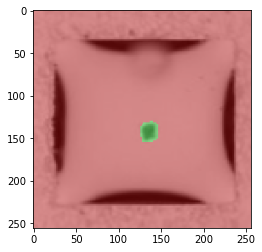

1
(256, 256)
2022-07-08 18:39:46,778 [WARNING] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


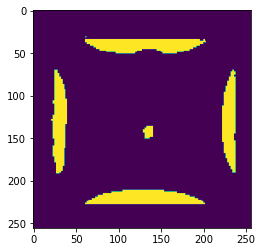

1
(256, 256)
2022-07-08 18:39:46,942 [WARNING] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


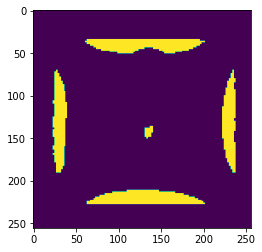

2022-07-08 18:39:47,085 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2022-07-08 18:39:48,304 [WARNING] WARNING: not interp
2022-07-08 18:39:48,493 [INFO] estimated cell diameter(s) in 1.41 sec
2022-07-08 18:39:48,494 [INFO] >>> diameter(s) = 
2022-07-08 18:39:48,495 [INFO] [ 30.00 ]
2022-07-08 18:39:48,495 [INFO] ~~~ FINDING MASKS ~~~
2022-07-08 18:39:49,539 [INFO] >>>> TOTAL TIME 2.45 sec
1
(256, 256)
2022-07-08 18:39:49,551 [WARNING] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


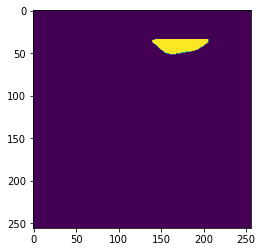

1
(256, 256)
2022-07-08 18:39:49,730 [WARNING] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


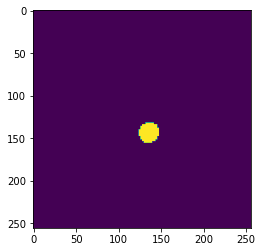

In [20]:
# look up
# DERMA
# 0.04: /home/ws/sc1357/data/$RESULT_DIR/20220708_1427_0005_dnn_model.tar
# 0.08: /home/ws/sc1357/data/$RESULT_DIR/20220708_1426_0007_dnn_model.tar
# 0.16: /home/ws/sc1357/data/$RESULT_DIR/20220708_1435_0004_dnn_model.tar
# 0.32: /home/ws/sc1357/data/$RESULT_DIR/20220708_1505_0006_dnn_model.tar

# DMA Sphero
# 0.04: /home/ws/sc1357/data/$RESULT_DIR/20220708_1432_0000_dnn_model.tar
# 0.08: /home/ws/sc1357/data/$RESULT_DIR/20220708_1431_0001_dnn_model.tar
# 0.16: /home/ws/sc1357/data/$RESULT_DIR/20220708_1428_0002_dnn_model.tar
# 0.32: /home/ws/sc1357/data/$RESULT_DIR/20220708_1429_0003_dnn_model.tar

import tifffile
from skimage.io import imread, imsave    
import numpy as np
import matplotlib.pyplot as plt
from DLIP.utils.metrics.seg_metrics import get_dsc
import cv2 
from skimage.color import label2rgb

class StatusBar:
    def __init__(self, ):
        pass
    def showMessage(self, msg):
        pass

img = tifffile.imread('/home/ws/sc1357/data/datasets/2022_DMA_Spheroid_BF/2022_DMA_Spheroid_Detection_split/test/samples/A945_spot_row_11_col03.tif')
label = tifffile.imread('/home/ws/sc1357/data/datasets/2022_DMA_Spheroid_BF/2022_DMA_Spheroid_Detection_split/test/labels/A945_spot_row_11_col03_label.tif').squeeze().astype(np.uint8)
# img =  imread('/home/ws/sc1357/data/datasets/2017_ISIC_Derma/test/samples/ISIC_0014077.jpg')
# label = (imread('/home/ws/sc1357/data/datasets/2017_ISIC_Derma/test/labels/ISIC_0014077_segmentation.png').squeeze()>0).astype(np.uint8)
pre_anno_lst = []

PREFIX = "dma_sphero_2"

img = cv2.resize(img, (256,256), interpolation=cv2.INTER_NEAREST)
label = cv2.resize(label, (256,256), interpolation=cv2.INTER_NEAREST)

from DLIP.pre_labeling.segmentation.pre_labeler_otsu_seg import PreLabelerOtsuSeg
from DLIP.pre_labeling.segmentation.pre_labeler_percentile_seg import PreLabelerPercentileSeg
from DLIP.pre_labeling.segmentation.pre_label_unet import UnetSemanticPreLabeler
from DLIP.pre_labeling.instance_segmentation.pre_labeler_cellpose import Cellpose

pre_anno_lst.append(PreLabelerOtsuSeg(do_closing=False, inverse=True))
pre_anno_lst.append(PreLabelerPercentileSeg(10, inverse=True))
pre_anno_lst.append(Cellpose(model_type="cyto", use_gpu=True))
pre_anno_lst.append(UnetSemanticPreLabeler("/home/ws/sc1357/data/$RESULT_DIR/20220708_1429_0003_dnn_model.tar"))

imsave(f"{PREFIX}_org.png", img)

plt.imshow(img)
plt.show()


overlay = label2rgb(label.squeeze(), img, bg_label=0,bg_color=(1,0,0), alpha=0.3, colors=[(0,1,0),])
imsave(f"{PREFIX}_gt.png", overlay)
plt.imshow(overlay)
plt.show()

for method in pre_anno_lst:
    pre_anno = method.predict(img, StatusBar()).astype(np.uint8)
    pre_anno = (pre_anno>0).astype(np.uint8)
    dsc = get_dsc(
        np.expand_dims(np.expand_dims(label, axis=-1), axis=-1),
        np.expand_dims(np.expand_dims(pre_anno, axis=-1), axis=-1)
    )
    
    overlay = label2rgb(pre_anno.squeeze(), img, bg_label=0,bg_color=(1,0,0), alpha=0.3, colors=[(0,1,0),])
    imsave(f"{PREFIX}_{method.__class__.__name__}_DSC_{str(dsc).replace('.', 'p')}.png", overlay)
    plt.imshow(pre_anno)
    plt.show()


